# 🌺 고객 대출등급 분류 해커톤 - BASE
Evaluation Metric : Macro F1<br>
Public Score : 전체 테스트 데이터 중 30%<br>
Dead Line : 24-02-05 AM 10:00

In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample = pd.read_csv('data/sample_submission.csv')

## 1) 데이터 탐색

In [17]:
train.shape, test.shape

((96294, 15), (64197, 14))

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96294 entries, 0 to 96293
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            96294 non-null  object 
 1   대출금액          96294 non-null  int64  
 2   대출기간          96294 non-null  object 
 3   근로기간          96294 non-null  object 
 4   주택소유상태        96294 non-null  object 
 5   연간소득          96294 non-null  int64  
 6   부채_대비_소득_비율   96294 non-null  float64
 7   총계좌수          96294 non-null  int64  
 8   대출목적          96294 non-null  object 
 9   최근_2년간_연체_횟수  96294 non-null  int64  
 10  총상환원금         96294 non-null  int64  
 11  총상환이자         96294 non-null  float64
 12  총연체금액         96294 non-null  float64
 13  연체계좌수         96294 non-null  float64
 14  대출등급          96294 non-null  object 
dtypes: float64(4), int64(5), object(6)
memory usage: 11.0+ MB


In [49]:
train.head()

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,TRAIN_00003,14400000,36 months,8 years,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,TRAIN_00004,18000000,60 months,Unknown,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B


In [4]:
# train.dtypes[train.dtypes == 'float64'].index.tolist()

In [57]:
# deci = False

# for data in train['연체계좌수']:
#     if data %1 != 0 :
#         print('소수점 데이터 있음')
#         deci = True
#         break

# if not deci:
#     print('모두 정수 값')

모두 정수 값


In [19]:
train.isnull().sum()

ID              0
대출금액            0
대출기간            0
근로기간            0
주택소유상태          0
연간소득            0
부채_대비_소득_비율     0
총계좌수            0
대출목적            0
최근_2년간_연체_횟수    0
총상환원금           0
총상환이자           0
총연체금액           0
연체계좌수           0
대출등급            0
dtype: int64

### - object feature
  - 'ID' : 고객 아이디
  - '대출기간' : (categort, 2개) 36months, 60months 
  - '근로기간' : 데이터 가공 필수, 수치형으로 변경, unknown 5.8%
  - '주택소유상태' : (categori, 4개) MORTGAGE(대출), RENT, OWN, ANY? 
  - '대출목적' : (categori, 12개) ['부채 통합','신용 카드', '주택 개선','기타','주요 구매','의료','자동차','소규모 사업','이사','휴가','주택','재생 에너지']
  - '대출등급' : (categori, 7개)target data

### - integer feature
  - '대출금액'
  - '연간소득'
  - '총계좌수'
  - '최근_2년간_연체_횟수' : 0~30회, 0회가 79.3% 차지
  - '총상환원금'

### - float feature
  - '부채_대비_소득_비율'
  - '총상환이자' : 정수로 변경 가능
  - '총연체금액' : 정수로 변경 가능
  - '연체계좌수' : 정수로 변경 가능

## 2) 데이터 전처리

In [3]:
all_df = pd.concat([train,test])

#### ● 근로기간 column을 수치형으로 변경

In [4]:
all_df['근로기간'].value_counts().index.tolist()

['10+ years',
 '2 years',
 '< 1 year',
 '3 years',
 '1 year',
 '5 years',
 'Unknown',
 '4 years',
 '8 years',
 '6 years',
 '7 years',
 '9 years',
 '10+years',
 '<1 year',
 '3',
 '1 years']

In [5]:
# '10+ years'.split()[0]

In [6]:
def to_num(value):
    try:
        return int(value.split()[0])
    except ValueError:
        if value in ('10+ years','10+years'):
            return 10
        elif value in ('< 1 year','<1 year'):
            return 0
        else:
            return np.nan

In [7]:
data = df['근로기간']
data = data.apply(to_num)
data.value_counts(dropna=False)

10.0    54034
2.0     14059
0.0     13546
3.0     12755
1.0     10579
5.0      9592
NaN      9533
4.0      9250
8.0      8172
6.0      6353
7.0      6329
9.0      6289
Name: 근로기간, dtype: int64

In [8]:
all_df['근로기간'] = data

#### ● 불필요한 실수항 정수로 변경

In [9]:
col = ['총상환이자','총연체금액','연체계좌수']
all_df[col] = all_df[col].astype(int)

#### ● 카테고리 항목 라벨 인코딩

In [10]:
all_df.dtypes[all_df.dtypes == 'object'].index.tolist()

['ID', '대출기간', '주택소유상태', '대출목적', '대출등급']

In [11]:
col = ['대출기간', '주택소유상태', '대출목적']
for c in col:
    all_df[c] = pd.factorize(all_df[c])[0]

#### ● train, test 분리

In [12]:
train = all_df[~all_df['대출등급'].isnull()]
test = all_df[all_df['대출등급'].isnull()].drop('대출등급',axis=1)
print(train.shape, test.shape)

(96294, 15) (64197, 14)


## 3) 모델 학습

In [13]:
import optuna
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, train_test_split

C:\Users\USER\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### ● 대략적인 하이퍼파라미터 탐색

In [17]:
def objective_lgbm(trial):
    
    params = {
              'objective': 'multiclass', 'num_class': 7,
              'max_depth': trial.suggest_int('max_depth',10,20),
              'num_leaves' : trial.suggest_int('num_leaves',24,64),
              'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
              'min_child_weight': trial.suggest_int('min_child_weight', 1, 40),
              'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.06),
              # 'n_estimators': trial.suggest_int('n_estimators', 275, 2000),
              'subsample': trial.suggest_float('subsample', 0.5, 1.0),
              'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.2),
              'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10),
              'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 20),
              'random_state': 2024
            }


    model = LGBMClassifier(**params, verbose=-1)

    scores = cross_val_score(model, X , y, cv=5, scoring='neg_log_loss')

    return -scores.mean()

In [27]:
study = optuna.create_study(direction='minimize')
study.optimize(objective_lgbm, n_trials=30)  # Adjust the number of trials to 100-1000
best_params = study.best_params
print('Best Parameters:', best_params)

[I 2024-02-03 14:15:25,713] A new study created in memory with name: no-name-686d84e0-03e9-4264-9207-2c3ae1a52d5a
[I 2024-02-03 14:15:37,485] Trial 0 finished with value: 1.2581844458447033 and parameters: {'max_depth': 16, 'num_leaves': 38, 'min_child_samples': 100, 'min_child_weight': 38, 'learning_rate': 0.050865435644273066, 'subsample': 0.9564589279739316, 'colsample_bytree': 0.12410451831331479, 'reg_alpha': 5.323284286511127, 'reg_lambda': 9.876845714255827}. Best is trial 0 with value: 1.2581844458447033.
[I 2024-02-03 14:15:49,561] Trial 1 finished with value: 1.2330609579624194 and parameters: {'max_depth': 13, 'num_leaves': 44, 'min_child_samples': 60, 'min_child_weight': 25, 'learning_rate': 0.058507718699505246, 'subsample': 0.8842961536456271, 'colsample_bytree': 0.12869547632682204, 'reg_alpha': 8.777213681599958, 'reg_lambda': 9.460588363525325}. Best is trial 1 with value: 1.2330609579624194.
[I 2024-02-03 14:16:02,848] Trial 2 finished with value: 1.224521027175987 an

Best Parameters: {'max_depth': 10, 'num_leaves': 41, 'min_child_samples': 36, 'min_child_weight': 15, 'learning_rate': 0.038271390011357716, 'subsample': 0.8240659327203188, 'colsample_bytree': 0.1991348172483006, 'reg_alpha': 1.814111538332781, 'reg_lambda': 3.115892763637826}


#### ● lgbm 학습

In [14]:
X = train.drop(['ID','대출등급'], axis=1)
y = train['대출등급']

In [15]:
xt, xv, yt, yv = train_test_split(X,y,
                                 test_size = 0.25,
                                 random_state = 2024)

xt.shape, xv.shape

((72220, 13), (24074, 13))

In [26]:
params = {'n_estimators': 1000,
          'max_depth': 10, 
          'num_leaves': 41, 
          'min_child_samples': 36, 
          'min_child_weight': 15, 
          'learning_rate': 0.038271390011357716, 
          'subsample': 0.8240659327203188, 
          'colsample_bytree': 0.1991348172483006, 
          'reg_alpha': 1.814111538332781, 
          'reg_lambda': 3.115892763637826,
          'verbose': -1,
         }

In [27]:
model = LGBMClassifier(**params)
model.fit(xt, yt, eval_set = [(xt,yt),(xv,yv)],
          eval_metric = 'multi_logloss',
          callbacks = [lgb.early_stopping(stopping_rounds=50), 
                      lgb.log_evaluation(period=100)])

Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 1.09615	valid_1's multi_logloss: 1.11603
[200]	training's multi_logloss: 0.91235	valid_1's multi_logloss: 0.949527
[300]	training's multi_logloss: 0.815509	valid_1's multi_logloss: 0.866821
[400]	training's multi_logloss: 0.724308	valid_1's multi_logloss: 0.786201
[500]	training's multi_logloss: 0.664288	valid_1's multi_logloss: 0.736197
[600]	training's multi_logloss: 0.615883	valid_1's multi_logloss: 0.696274
[700]	training's multi_logloss: 0.57689	valid_1's multi_logloss: 0.664652
[800]	training's multi_logloss: 0.546274	valid_1's multi_logloss: 0.641191
[900]	training's multi_logloss: 0.510113	valid_1's multi_logloss: 0.61041
[1000]	training's multi_logloss: 0.487786	valid_1's multi_logloss: 0.593985
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.487786	valid_1's multi_logloss: 0.593985


LGBMClassifier(colsample_bytree=0.1991348172483006,
               learning_rate=0.038271390011357716, max_depth=10,
               min_child_samples=36, min_child_weight=15, n_estimators=1000,
               num_leaves=41, reg_alpha=1.814111538332781,
               reg_lambda=3.115892763637826, subsample=0.8240659327203188,
               verbose=-1)

In [ ]:
# [1000]	training's multi_logloss: 0.691546	valid_1's multi_logloss: 0.759675
# [1000]	training's multi_logloss: 0.487786	valid_1's multi_logloss: 0.593985

#### ● feature importance 그래프 확인

In [30]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

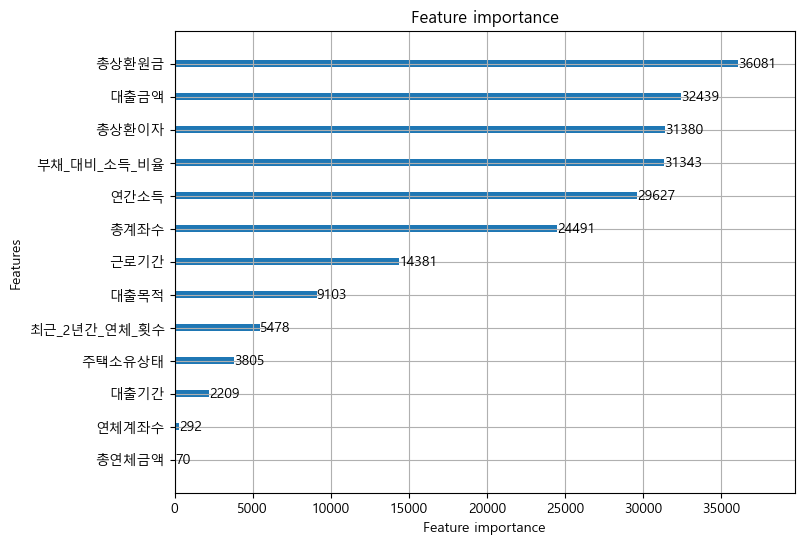

In [34]:
from lightgbm import plot_importance
plot_importance(model, figsize=(8, 6))

#### ● result.csv 제출파일 저장

In [46]:
test.sample(5)

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
11299,TEST_11299,6000000,0,10.0,1,111600000,9.25,21,1,1,458340,88104,0,0
25928,TEST_25928,26490000,1,7.0,2,72000000,1.08,9,1,0,577188,666228,0,0
53493,TEST_53493,12000000,1,10.0,1,63000000,19.38,30,0,0,491004,236616,0,0
48741,TEST_48741,6000000,0,10.0,1,72000000,15.15,46,0,0,288468,92040,0,0
15611,TEST_15611,12000000,0,6.0,0,115200000,17.23,31,0,1,1193088,314796,0,0


In [40]:
id_list = test['ID']
pred = model.predict(test.drop(['ID'],axis=1))

In [51]:
dic = {'ID' : id_list,
      '대출등급' : pred}
result = pd.DataFrame(dic)

In [54]:
result.to_csv('submit00.csv', index=False)

In [55]:
# 0.7145점 수상이 0.92정도......^^.....